# 2. Image classification with CNN
* cnn을 이용하여 다음 이미지를 분류하여라.
* 인풋 데이터는 rgb 정보를 가지고 있다.
* 코드, 결과, 보고서를 함께 제출하여야 한다.
* 자신의 코드에 대한 설명을 주석으로 적기
* 결과에 대한 해석을 보고서로 작성 (코드 아래 마크다운 이용, 1page 분량)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
#data 다운받고 batch 설정
batch_size = 64
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False
)

classes = trainset.classes
classes

Files already downloaded and verified
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

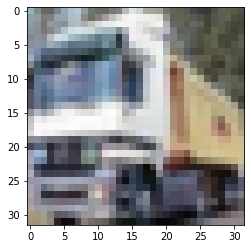

In [5]:
import matplotlib.pyplot as plt

images = train_loader.dataset[1][0]
plt.imshow(images.permute(1, 2, 0))

In [6]:
images.size() # [3, 32, 32]: 3 -> RGB, 32x32

torch.Size([3, 32, 32])

In [28]:
import torch.nn as nn
import torch.nn.functional as F
class cnn(nn.Module):   #class이용하여 모델 작성, cnn사용
    def __init__(self): #convolution
        super(cnn, self).__init__() 
        self.conv1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) #이미지 컨볼루젼에서 Conv2d 사용, RGB이므로 in_channels=3
        self.conv2=nn.Conv2d(16,32,3, padding=1) #conv1의 값에 맞춰 in_channels 설정
        self.fc1=nn.Linear(8*8*32, 64) #kernel size, out_channels에 맞춰 행렬 크기 설정, 차원축소
        self.fc2=nn.Linear(64,10)   #종류가 10개이므로 output 10개
        self.dropout=nn.Dropout(0.5) #overfitting방지를 위해 dropout 도입

    def forward(self, x): #위의 convolution 사용하고 추가로 max pooling사용하여(max_pool2d) 정방향 연산 진행
        x=self.conv1(x) #convolution
        x=F.relu(x) #activation function으로 relu함수를 사용
        x=self.dropout(x) #dropout
        x=F.max_pool2d(x,2) #max pooling
        x=self.conv2(x) #convolution
        x=F.relu(x) #activation function으로 relu함수를 사용
        #x=self.dropout(x) ->dropout이 과하여 오히려 학습이 제대로 안됨 
        x=F.max_pool2d(x,2) #max pooling
        x=torch.flatten(x,1) #규격에 맞춰 data를 flat하게 변형
        x=self.fc1(x) #차원축소
        x=F.relu(x) #activation function으로 relu함수를 사용
        #x=self.dropout(x) ->dropout이 과하여 오히려 학습이 제대로 안됨
        x=self.fc2(x) #10개 output 나옴
        x=F.softmax(x,dim=1) #softmax 사용, dim=1의 뜻은 모든 확률의 합을 1로 해줌.
        return x

In [20]:
model=cnn() #model을 위의 cnn으로 사용
criterion=nn.CrossEntropyLoss() #error를 cross entropy로 계산
optimizer=torch.optim.Adam(model.parameters(),lr=0.001) #optimizer는 Adam을 사용, lr는 learning rate

In [21]:
def train(model, criterion, optimizer, data): #학습하는 함수
    model.train() #모듈을 train mode로
    for X,y in data: #후에 data에서 X,y를 가져옴
        y_pred=model(X) #model에 X값 대입후 값 계산
        loss=criterion(y_pred,y) #loss계산
        optimizer.zero_grad() #optimizer 0으로 초기화
        loss.backward() #backpropagation
        optimizer.step() # parameter업데이트

In [22]:
def evaluation(model, criterion, optimizer, data): #오차계산 함수
    model.eval() #모듈을 evaluation mode로
    loss=0 #초기값 0으로
    acc=0
    with torch.no_grad(): #auto grad 사용x
        for X, y in data: #후에 data에서 X,y를 가져옴
            y_pred=model(X) #model에 X값 대입후 값 계산
            loss+=criterion(y_pred, y) #위의 값과 실제값의 오차계산 후 loss에 저장
            pred=y_pred.max(1)[1] #최종 예측값
            cor=(pred==y) #예측값과 맞는것 찾음
            acc+=cor.sum().float()/float(y.size(0)) #정확도 계산후 acc에 저장
    return loss, acc  #test_loss, accuracy 값 반환

In [33]:
nums_epoch=11 #반복 횟수
for epoch in range(nums_epoch): 
    train(model, criterion, optimizer,train_loader) #train_loader data로 학습

    if(epoch%2==0): #만약 반복 횟수가 2의 배수일 때
        loss, acc=evaluation(model, criterion, optimizer,test_loader) #evaluation 함수에서 test data로 loss, acuu값을 받아와서
        print(epoch, "loss=", loss.item(), "accu=", acc.item()) #해당 반복횟수마다 loss와 accu를 print

0 loss= 287.6382141113281 accu= 98.4375
2 loss= 289.5259704589844 accu= 96.40625
4 loss= 292.4839782714844 accu= 93.5625
6 loss= 287.56231689453125 accu= 98.453125
8 loss= 287.3316955566406 accu= 98.6875
10 loss= 287.8839416503906 accu= 98.125


2017018027 이윤우 "머신러닝과 물리학" final 과제-2번 보고서  
 이번 과제는 torchvision 의 “CIFAR10” dataset 을 CNN을 이용하여 분류하는 문제입니다. dataset 을 불러올 때 batch를 만들어 data를 쪼개 학습을 용이하게 했습니다. batch size는 아무렇게나 지정해도 남은 데이터에 대해 알아서 처리해줍니다. 모델은 class를 이용하여 만들었습니다. class를 이용하면 복잡한 코드를 쉽게 호출하고 사용할 수 있습니다. 모델에서 convolution, max pooling, dropout을 포함했다는 것을 제외하면, 나머지(학습, backpropagation 등의 과정)는 다른 neural network와 비슷합니다. CNN에서 사용하는 개념들에 대해 설명하면, 먼저 convolution은 합성곱 이라고 하며, 두 개의 함수를 연산하여 다른 함수를 만드는 연산입니다. 이미지의 글자 크기가 달라지거나 회전되는 등, 같은 이미지가 단순한 형태로라도 변형되었을 때 올바르게 구분하지 못하는 현상을 convolution이 해결해줍니다. pooling은 여러 개의 뉴런을 하나의 출력으로 바꾸는 과정을 말합니다. pooling 과정을 거치면서 다른 스케일의 정보를 추출할 수 있습니다. 정해진 pooling size에서 최댓값을 뽑아내는 max pooling과 평균값을 계산하여 받아오는 average pooling이 있는데, 과제에선 max pooling을 사용하였습니다.   
 코드 작성 초기엔 dropout을 적용하지 않고 코드를 작성하였는데, 정확도가 100%를 넘어가 overfitting 이 되었습니다. overfitting이란, 과적합 이라고 하며 말 그대로 학습이 과하게 되는 현상입니다. 문제 해결을 위해 dropout을 도입하였습니다. dropout이란, 여러개의 노드 중 확률적으로 몇 개의 노드만 선택하여 학습하는 방법입니다. 학습이 조금 덜 될 수도 있지만, 일반화 능력을 키워 overfitting을 막을 수 있습니다. dropout은 일반적으로 activation function 뒤, pooling 전에 적용합니다. 처음엔 모든 과정에 dropout을 적용하였더니 학습이 너무 안 되고 정확도가 80%대에 머물렀습니다. 그래서 dropout을 2번, 1번만 각각 적용해본 결과, 1번만 적용했을 때가 가장 학습이 잘 되었고, overfitting도 일어나지 않았습니다. 위의 과정을 통한 학습의 결과, 정확도를 98%까지 끌어올릴 수 있게 되었습니다.   
 저번 과제를 할 때만 해도 작성하는 코드가 각각 무엇을 의미하고, 무슨 역할을 하는지 확실히 이해하지 못했는데 이번 과제를 하며 각 줄마다 주석으로 의미를 작성하는 과정에서 CNN에 대해 잘 이해하게 되었습니다. 또한 class 이용법을 익혔고 그 외 인공신경망 알고리즘 작성법(정방향 계산, backpropagation 등)을 확실히 숙지하는 등 python 코딩 실력 측면에서도 한 단계 성장하게 되었습니다. 이렇게 배운 내용들이 사실 조금은 어렵지만, 따로 심화적으로 더 공부하여 kaggle 등을 이용해 여러 인공신경망 구조를 작성해볼 계획입니다.